# Generating Text with an RNN

In [1]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [4]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [5]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

 love to Theseus?
Didst thou not lead him through the glimmering night
From Perigenia, whom he ravished?
And make him with fair AEgle break his faith,
With Ariadne and Antiopa?

TITANIA:
These are the 


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [7]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [8]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [9]:
batch_size = 100
n_epochs = 2000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [10]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [11]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size, length = input.shape
    
    hidden_start = rnn.init_hidden(batch_size, device)
    hidden = hidden_start
    
    running_loss = torch.zeros((1)).to(device)
    optimizer.zero_grad()
    for i in range(length):
        
        curr_input = input[:,i]
        curr_target = target[:,i]
        output, hidden = rnn(curr_input, hidden)
        
        running_loss += criterion(output.view(batch_size, -1), curr_target.view(batch_size))
        
    running_loss /= length
    running_loss.backward()
    optimizer.step()
    loss = running_loss.data.cpu().numpy()[0]
    ##########       END      ##########

    return loss


In [12]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 2000 epochs...
 31s (50 2%) train loss: 2.1021, test_loss: 2.1042]
Whils me cownust thoum wistare
Giow that whit, that and, gould this the
bes? what ind you but me and l 

 1s (100 5%) train loss: 1.9609, test_loss: 1.9620]
Whing ters ulouscear, bade, and sirs.

KIARINA:
I tele sour she lanftenf it live deed one wall courd t 

 32s (150 7%) train loss: 1.9003, test_loss: 1.8861]
Whink you, for with the mer! me fall Triess:
We call.

KING CEPHESS EMPELHE HENRY VIS:
Thy beneht
I'll 

 2s (200 10%) train loss: 1.8386, test_loss: 1.8413]
Whe lordaught of is suimed crope-never.

First his mindly honest,
What.
Do your that dree all aro fath 

 33s (250 12%) train loss: 1.7790, test_loss: 1.8333]
Which liechice and feep a take!

EDELINIUS:
As the graint, reaking as any it did of my parrong count w 

 4s (300 15%) train loss: 1.7612, test_loss: 1.8060]
Why where you me juster, bether his least: suep the say,
This come;
The cear of lady her spencuicking
 

 36s (350 17%) train loss

In [13]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

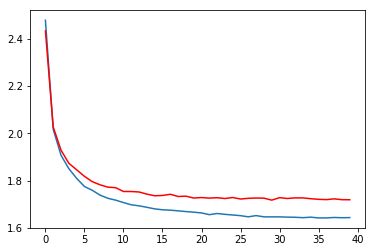

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [15]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Thy, thou for devise eyes uncliet there is here in thee, thou wears in me the great not be that hutide!
O, should tenders of stand and be from not who are lady then the please you a king,
But the spedeed can that the witily known:
Would not take them be retuptle under vapone so lie,
Stay, ave conforn with the sleep my hand,
Whilt me the their leave will their king.

EDWARSHESES:
Pears dely set I became.'

PORTIA:
For their power.
The see the only gods, many to dead, my matter, there be Forn known holt of for a better be pudent nose cright with the unclamed him lovello! Rushe
but
Believe?

Seis by God
Of thee?

Gentle
it a rest we night:
But with demick spirin in Brie and villair is the hontimon me.

CASSIUS:
Was strong welly you walking beloor: here would did help's fear sight on, you will,
As well devorth but in might too gone the Codes of our seeking thy is fast a wising me.

OCTITES:
O sood duke with upon this proffice, but harm is of a man better I have no masted: it rest, this bay

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

Training for 2000 epochs...
 30s (50 2%) train loss: 2.0837, test_loss: 2.0776]
What frair:
This tall mans, mour
sol: Man swath Port he hath in for kicer ligh, hean ture in a lest co 

 59s (100 5%) train loss: 1.8910, test_loss: 1.9035]
Wher norwetled my mive let in thind not the the's oud have bread montiness, hith to pamed what wet be  

 29s (150 7%) train loss: 1.8267, test_loss: 1.8361]
Whis coull be among in to the livery bown dreat, is hime tooles, and wecay,
To a say none my that come 

 59s (200 10%) train loss: 1.7412, test_loss: 1.7907]
Whisk mick or are a hard
On old heart is theated dave,
Till Remow I had it pased me that but this I sa 

 29s (250 12%) train loss: 1.6902, test_loss: 1.7705]
Wherize
Lull; ise him on housed with is find from in all, as of down
He wass confing,
O nate stand who 

 59s (300 15%) train loss: 1.6769, test_loss: 1.7427]
Whan that to both to taken.

MARK ANTONY:
What a should he did should endour
the mown the retiness'd e 

 29s (350 17%) train l

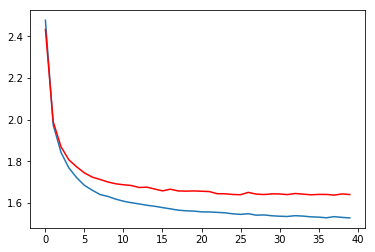

In [16]:
### GRU

rnn = RNN(n_characters, hidden_size, n_characters, model_type="gru", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 2000 epochs...
 22s (50 2%) train loss: 2.1319, test_loss: 2.1254]
What owre, in suatt ron'che the hiries anoutept beder beo fould wiraan, ir dows this way trome blenea  

 45s (100 5%) train loss: 1.9502, test_loss: 1.9602]
Wher with the pass by is mons, oth'd the that torly morry of int
Where my servould I sear his not but  

 8s (150 7%) train loss: 1.8540, test_loss: 1.8620]
Whill one theaction to shall ace he seep,
Hath not furms nose mister I should pready ack; chickers my  

 31s (200 10%) train loss: 1.7494, test_loss: 1.8077]
Wher roouse, would your ned the poortold betool thou not beak thee cascreyest if the revilk trummany t 

 54s (250 12%) train loss: 1.7140, test_loss: 1.7570]
What with was posted that all a withish,
And be this sent;
The misage beward.

MITORY CADWIZE:
Look la 

 17s (300 15%) train loss: 1.7021, test_loss: 1.7741]
Where in can a pray wind.

JOLIA QUEER:
What seve hather the leave you an in him lakeness,
And sidest  

 40s (350 17%) train lo

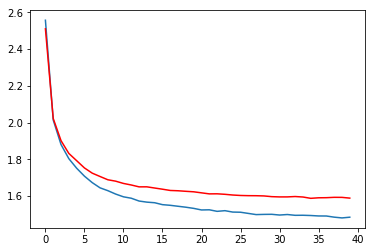

In [17]:
### LSTM

rnn = RNN(n_characters, hidden_size, n_characters, model_type="lstm", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 2000 epochs...
 34s (50 2%) train loss: 2.4718, test_loss: 2.4895]
Who de wat,icl yow hfonis ligour to mae
mouy anog mor the poo;cont bepig, ang'salouIpKom ben

IDXmfo w 

 9s (100 5%) train loss: 2.2424, test_loss: 2.2313]
Whe ghis maint larsus us no that suth ip ther for havren ande thus youch.

PELILR:
ENR: Ir:
That may f 

 45s (150 7%) train loss: 2.0962, test_loss: 2.1326]
Whan thy for sier this your for.
Werenter ave mone
The parnade
's rain mpecturkers.

MUSE:
If in reeld 

 20s (200 10%) train loss: 2.0453, test_loss: 2.0583]
Whone
The feon and my sorne our thou, me laster fall now if and thy to he lessen's Tor as the that $nd 

 54s (250 12%) train loss: 1.9634, test_loss: 1.9857]
When and in me and the ret, your stion and and that you brong;
Fis of indich a hopreable,
With undente 

 29s (300 15%) train loss: 1.9271, test_loss: 1.9597]
WhG now comen
well that my sallow, law's a comy in the for think so with illanty mar, 'er cames the ve 

 4s (350 17%) train los

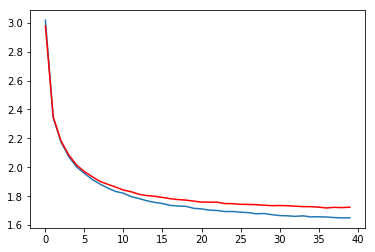

In [18]:
### RNN

learning_rate=0.002

rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 2000 epochs...
 34s (50 2%) train loss: 1.9936, test_loss: 2.0011]
Wher now que shall say leat?

BREA:
Wher but the mane me knat proth tremassure is my pith the hane por 

 8s (100 5%) train loss: 1.8106, test_loss: 1.8465]
What mark of it abouten; near the pear, selance I'll here anour did nevery a mance: thy Dored, then th 

 43s (150 7%) train loss: 1.6685, test_loss: 1.7647]
Where sover marefore oberving for their sadure on hut hither,
A shall that is your, he is but the gray 

 18s (200 10%) train loss: 1.6444, test_loss: 1.7061]
Why abattlem:
Before, Sinfure of they hath bears, at I to bight, beward,
And but this choil
fentlem'd  

 52s (250 12%) train loss: 1.5828, test_loss: 1.6625]
What into othermed?

CELIA: O frumpent or fell the privon?

All'd you are or the gater
Of her fair tha 

 27s (300 15%) train loss: 1.5919, test_loss: 1.6149]
Why distress my lord,
With of a mellen, where they have a compasters and likeness
but but not come unt 

 1s (350 17%) train los

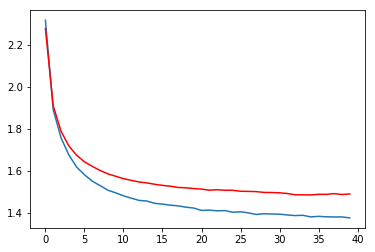

In [19]:
### GRU

hidden_size = 400
learning_rate = 0.003


rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 2000 epochs...
 44s (50 2%) train loss: 2.0489, test_loss: 2.0574]
Whe when
Y s, you sut fathen corith glouncure ar candly goon,
What and he moor this hasciost troughser 

 29s (100 5%) train loss: 1.8019, test_loss: 1.8115]
Whereave and pleason
boint heart.

CABENA:
A can lay
In in profless 'tin, sir, say, and in thought wil 

 13s (150 7%) train loss: 1.6479, test_loss: 1.7159]
What is come, made they day thou man:
I court
Past's love a pound of know die amen,
And my for here op 

 57s (200 10%) train loss: 1.5753, test_loss: 1.6742]
While the day; what for your cheer, I were bemore.

Seconder you well the heart.

HAMLO:
Have now.

HE 

 41s (250 12%) train loss: 1.4962, test_loss: 1.5861]
What see the other to I'll be ring at blust, past, he did lodger be speak aways.

DROMIO OF LEAR:
Hath 

 25s (300 15%) train loss: 1.4884, test_loss: 1.5594]
What he down to putting worth ambition would made was till thy way have to joy's under, the imong thou 

 9s (350 17%) train lo

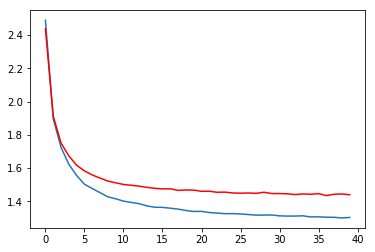

In [20]:
### RNN
n_layers=3

rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))